<a href="https://colab.research.google.com/github/Hermionee/Deep-learning/blob/master/reproduce_CO_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


# Generate Data

In [0]:
import requests
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.autograd import Variable
import torch
import os
import numpy as np
import re
import zipfile
import itertools
from collections import namedtuple
import matplotlib.pyplot as plt

In [0]:
torch.__version__

'1.0.1.post2'

In [0]:
# Training Data
class TSPDataset(Dataset):
    
    def __init__(self, dataset_fname=None, train=False, size=50, num_samples=100000, random_seed=1111):
        super(TSPDataset, self).__init__()
        
        torch.manual_seed(random_seed)

        self.data_set = []
        
        # randomly sample points uniformly from [0, 1]
        for l in tqdm(range(num_samples)):
            x = torch.FloatTensor(2, size).uniform_(0, 1)
            #x = torch.cat([start, x], 1)
            self.data_set.append(x)

        self.size = len(self.data_set)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.data_set[idx]

## DataLoader

In [0]:
import pprint as pp
import numpy as np

import torch
from torch.utils.data import DataLoader

In [0]:
input_dim = 2
size = 50
train_size = 100000
val_size = 1000
batch_size = 128

In [0]:
training_dataset = TSPDataset(train=True, size=size,
     num_samples=train_size)

val_dataset = TSPDataset(train=True, size=size,
        num_samples=val_size)

train_dataloader = DataLoader(training_dataset, batch_size=batch_size,
    shuffle=True, num_workers=4)

val_dataloader = DataLoader(val_dataset, batch_size=int(batch_size/2), shuffle=True, num_workers=1)

100%|██████████| 1000/1000 [00:00<00:00, 81008.65it/s]


# Neural Net Model

## Encoder

In [0]:
import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn.functional as F
import math
import numpy as np

In [0]:
class Encoder(nn.Module):
    """Maps a graph represented as an input sequence
    to a hidden vector"""
    def __init__(self, input_dim, hidden_dim, use_cuda):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.use_cuda = use_cuda
        self.enc_init_state = self.init_hidden(hidden_dim)

    def forward(self, x, hidden):
        output, hidden = self.lstm(x, hidden)
        return output, hidden
    
    def init_hidden(self, hidden_dim):
        """Trainable initial hidden state"""
        enc_init_hx = Variable(torch.zeros(hidden_dim), requires_grad=False)
        if self.use_cuda:
            enc_init_hx = enc_init_hx.cuda()

        #enc_init_hx.data.uniform_(-(1. / math.sqrt(hidden_dim)),
        #        1. / math.sqrt(hidden_dim))

        enc_init_cx = Variable(torch.zeros(hidden_dim), requires_grad=False)
        if self.use_cuda:
            enc_init_cx = enc_init_cx.cuda()

        #enc_init_cx = nn.Parameter(enc_init_cx)
        #enc_init_cx.data.uniform_(-(1. / math.sqrt(hidden_dim)),
        #        1. / math.sqrt(hidden_dim))
        return (enc_init_hx, enc_init_cx)

## Attention

In [0]:
class Attention(nn.Module):
    """A generic attention module for a decoder in seq2seq"""
    def __init__(self, dim, use_tanh=False, C=10, use_cuda=True):
        super(Attention, self).__init__()
        self.use_tanh = use_tanh
        # query matrix W_q
        self.project_query = nn.Linear(dim, dim)
        # refence matrix W_ref
        self.project_ref = nn.Conv1d(dim, dim, 1, 1)
        self.C = C  # tanh exploration
        self.tanh = nn.Tanh()
        
        v = torch.FloatTensor(dim)
        if use_cuda:
            v = v.cuda()  
        self.v = nn.Parameter(v)
        self.v.data.uniform_(-(1. / math.sqrt(dim)) , 1. / math.sqrt(dim))
        
    def forward(self, query, ref):
        """
        Args: 
            query: is the hidden state of the decoder at the current
                time step. batch x dim
            ref: the set of hidden states from the encoder. 
                sourceL x batch x hidden_dim
        """
        # ref is now [batch_size x hidden_dim x sourceL]
        ref = ref.permute(1, 2, 0)
        q = self.project_query(query).unsqueeze(2)  # batch x dim x 1
        e = self.project_ref(ref)  # batch_size x hidden_dim x sourceL 
        # expand the query by sourceL
        # batch x dim x sourceL
        expanded_q = q.repeat(1, 1, e.size(2)) 
        # batch x 1 x hidden_dim
        v_view = self.v.unsqueeze(0).expand(
                expanded_q.size(0), len(self.v)).unsqueeze(1)
        # [batch_size x 1 x hidden_dim] * [batch_size x hidden_dim x sourceL]
        u = torch.bmm(v_view, self.tanh(expanded_q + e)).squeeze(1)
        if self.use_tanh:
            logits = self.C * self.tanh(u)
        else:
            logits = u  
            
        # e is projected reference, logits is u
        # ref is used to compute glimpse: G = ref * softmax(u)
        
        # the logits has the same length with the number of cities
        # so softmax(logits) is exact the probability of each city
        return e, logits


## Decoder

In [0]:
'''
class Decoder(nn.Module):
    def __init__(self, 
            embedding_dim,
            hidden_dim,
            max_length,
            tanh_exploration,
            terminating_symbol,
            use_tanh,
            decode_type,
            n_glimpses=1,
            beam_size=0,
            use_cuda=True):
        super(Decoder, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_glimpses = n_glimpses
        self.max_length = max_length
        self.terminating_symbol = terminating_symbol 
        self.decode_type = decode_type
        self.beam_size = beam_size
        self.use_cuda = use_cuda

        self.input_weights = nn.Linear(embedding_dim, 4 * hidden_dim)
        self.hidden_weights = nn.Linear(hidden_dim, 4 * hidden_dim)

        self.pointer = Attention(hidden_dim, use_tanh=use_tanh, C=tanh_exploration, use_cuda=self.use_cuda)
        self.glimpse = Attention(hidden_dim, use_tanh=False, use_cuda=self.use_cuda)
        self.sm = nn.Softmax(dim=-1)

    def apply_mask_to_logits(self, step, logits, mask, prev_idxs):    
        if mask is None:
            mask = torch.zeros(logits.size()).byte()
            if self.use_cuda:
                mask = mask.cuda()
    
        maskk = mask.clone()

        # to prevent them from being reselected. 
        # Or, allow re-selection and penalize in the objective function
        if prev_idxs is not None:
            # set most recently selected idx values to 1
            maskk[[x for x in range(logits.size(0))],
                    prev_idxs.data] = 1
            # just implement the equation (8) in the paper
            logits[maskk] = -np.inf
        return logits, maskk

    def forward(self, decoder_input, embedded_inputs, hidden, context):
        """
        Args:
            decoder_input: The initial input to the decoder
                size is [batch_size x embedding_dim]. Trainable parameter.
            embedded_inputs: [sourceL x batch_size x embedding_dim]
            hidden: the prev hidden state, size is [batch_size x hidden_dim]. 
                Initially this is set to (enc_h[-1], enc_c[-1])
            context: encoder outputs, [sourceL x batch_size x hidden_dim] 
        """
        def recurrence(x, hidden, logit_mask, prev_idxs, step):
            
            hx, cx = hidden  # batch_size x hidden_dim
            
            gates = self.input_weights(x) + self.hidden_weights(hx)
            ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

            ingate = torch.sigmoid(ingate)
            forgetgate = torch.sigmoid(forgetgate)
            cellgate = torch.tanh(cellgate)
            outgate = torch.sigmoid(outgate)

            cy = (forgetgate * cx) + (ingate * cellgate)
            hy = outgate * torch.tanh(cy)  # batch_size x hidden_dim
            
            g_l = hy
            for i in range(self.n_glimpses):
                ref, logits = self.glimpse(g_l, context)
                logits, logit_mask = self.apply_mask_to_logits(step, logits, logit_mask, prev_idxs)
                # [batch_size x h_dim x sourceL] * [batch_size x sourceL x 1] = 
                # [batch_size x h_dim x 1]
                g_l = torch.bmm(ref, self.sm(logits).unsqueeze(2)).squeeze(2) 
            _, logits = self.pointer(g_l, context)
            
            # update the mask
            logits, logit_mask = self.apply_mask_to_logits(step, logits, logit_mask, prev_idxs)
            probs = self.sm(logits)
            return hy, cy, probs, logit_mask
    
        batch_size = context.size(1)
        outputs = []
        selections = []
        steps = range(self.max_length)  # or until terminating symbol ?
        inps = []
        idxs = None
        mask = None
       
        if self.decode_type == "stochastic":
            # for loop to get all city coordinates
            for i in steps:
                # the first decoder_input is just a trainable parameters
                # the next decoder_input is the embedded_inputs[idxs]
                hx, cx, probs, mask = recurrence(decoder_input, hidden, mask, idxs, i)
                # hidden contains two tensors with size [batch_size x hidden_dim]
                # and the (hy, cy) is the next (hx, cx)
                # the first hidden comes from the encoder
                hidden = (hx, cx)
                # select the next inputs for the decoder [batch_size x hidden_dim]
                decoder_input, idxs = self.decode_stochastic(
                    probs,
                    embedded_inputs,
                    selections)
                inps.append(decoder_input) 
                # use outs to point to next object
                outputs.append(probs)
                selections.append(idxs)
            return (outputs, selections), hidden
        
    def decode_stochastic(self, probs, embedded_inputs, selections):
        """
        Return the next input for the decoder by selecting the 
        input corresponding to the max output
        Args: 
            probs: [batch_size x sourceL]
            embedded_inputs: [sourceL x batch_size x embedding_dim]
            selections: list of all of the previously selected indices during decoding
       Returns:
            Tensor of size [batch_size x sourceL] containing the embeddings
            from the inputs corresponding to the [batch_size] indices
            selected for this iteration of the decoding, as well as the 
            corresponding indicies
        """
        batch_size = probs.size(0)
        # idxs is [batch_size]
        # idxs = probs.multinomial().squeeze(1)
        # idxs is the sampled city index
        c = torch.distributions.Categorical(probs)
        
        idxs = c.sample()
        
        # due to race conditions, might need to resample here
        for old_idxs in selections:
            # compare new idxs
            # elementwise with the previous idxs. If any matches,
            # then need to resample
            if old_idxs.eq(idxs).data.any():
                print(' [!] resampling due to race condition')
                idxs = probs.multinomial().squeeze(1)
                break
        
        # embedded inputs are the embedded city coordinates, the next index is idxs,
        # so the next embedded input is embedded_inputs[idex]
        sels = embedded_inputs[idxs.data, [i for i in range(batch_size)], :] 
        return sels, idxs
'''

In [0]:
class Decoder(nn.Module):
    def __init__(self, 
            embedding_dim,
            hidden_dim,
            max_length,
            tanh_exploration,
            terminating_symbol,
            use_tanh,
            decode_type,
            n_glimpses=1,
            beam_size=0,
            use_cuda=True):
        super(Decoder, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_glimpses = n_glimpses
        self.max_length = max_length
        self.terminating_symbol = terminating_symbol 
        self.decode_type = decode_type
        self.beam_size = beam_size
        self.use_cuda = use_cuda

        self.input_weights = nn.Linear(embedding_dim, 4 * hidden_dim)
        self.hidden_weights = nn.Linear(hidden_dim, 4 * hidden_dim)

        self.pointer = Attention(hidden_dim, use_tanh=use_tanh, C=tanh_exploration, use_cuda=self.use_cuda)
        self.glimpse = Attention(hidden_dim, use_tanh=False, use_cuda=self.use_cuda)
        self.sm = nn.Softmax(dim=-1)

    def apply_mask_to_logits(self, step, logits, mask, prev_idxs):    
        if mask is None:
            mask = torch.zeros(logits.size()).byte()
            if self.use_cuda:
                mask = mask.cuda()
    
        maskk = mask.clone()

        # to prevent them from being reselected. 
        # Or, allow re-selection and penalize in the objective function
        if prev_idxs is not None:
            # set most recently selected idx values to 1
            maskk[[x for x in range(logits.size(0))],
                    prev_idxs.data] = 1
            # just implement the equation (8) in the paper
            logits[maskk] = -np.inf
        return logits, maskk

    def forward(self, decoder_input, embedded_inputs, hidden, context):
        """
        Args:
            decoder_input: The initial input to the decoder
                size is [batch_size x embedding_dim]. Trainable parameter.
            embedded_inputs: [sourceL x batch_size x embedding_dim]
            hidden: the prev hidden state, size is [batch_size x hidden_dim]. 
                Initially this is set to (enc_h[-1], enc_c[-1])
            context: encoder outputs, [sourceL x batch_size x hidden_dim] 
        """
        def recurrence(x, hidden, logit_mask, prev_idxs, step):
            
            hx, cx = hidden  # batch_size x hidden_dim
            
            gates = self.input_weights(x) + self.hidden_weights(hx)
            ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

            ingate = torch.sigmoid(ingate)
            forgetgate = torch.sigmoid(forgetgate)
            cellgate = torch.tanh(cellgate)
            outgate = torch.sigmoid(outgate)

            cy = (forgetgate * cx) + (ingate * cellgate)
            hy = outgate * torch.tanh(cy)  # batch_size x hidden_dim
            
            g_l = hy
            for i in range(self.n_glimpses):
                ref, logits = self.glimpse(g_l, context)
                logits, logit_mask = self.apply_mask_to_logits(step, logits, logit_mask, prev_idxs)
                # [batch_size x h_dim x sourceL] * [batch_size x sourceL x 1] = 
                # [batch_size x h_dim x 1]
                g_l = torch.bmm(ref, self.sm(logits).unsqueeze(2)).squeeze(2) 
            _, logits = self.pointer(g_l, context)
            
            # update the mask
            logits, logit_mask = self.apply_mask_to_logits(step, logits, logit_mask, prev_idxs)
            probs = self.sm(logits)
            return hy, cy, probs, logit_mask
    
        batch_size = context.size(1)
        outputs = []
        selections = []
        steps = range(self.max_length)  # or until terminating symbol ?
        inps = []
        idxs = None
        mask = None
       
        if self.decode_type == "stochastic":
            # for loop to get all city coordinates
            for i in steps:
                # the first decoder_input is just a trainable parameters
                # the next decoder_input is the embedded_inputs[idxs]
                hx, cx, probs, mask = recurrence(decoder_input, hidden, mask, idxs, i)
                # hidden contains two tensors with size [batch_size x hidden_dim]
                # and the (hy, cy) is the next (hx, cx)
                # the first hidden comes from the encoder
                hidden = (hx, cx)
                # select the next inputs for the decoder [batch_size x hidden_dim]
                decoder_input, idxs = self.decode_stochastic(
                    probs,
                    embedded_inputs,
                    selections)
                inps.append(decoder_input) 
                # use outs to point to next object
                outputs.append(probs)
                selections.append(idxs)
            return (outputs, selections), hidden
                
        elif self.decode_type == "greedy":
            for i in steps:
                hx, cx, probs, mask = recurrence(decoder_input, hidden, mask, idxs, i)
                hidden = (hx, cx)
                decoder_input, idxs = self.decode_greedy(
                    probs,
                    embedded_inputs,
                    selections)
                inps.append(decoder_input) 
                outputs.append(probs)
                selections.append(idxs)
                
            return (outputs, selections), hidden
        
    def decode_stochastic(self, probs, embedded_inputs, selections):
        """
        Return the next input for the decoder by selecting the 
        input corresponding to the max output
        Args: 
            probs: [batch_size x sourceL]
            embedded_inputs: [sourceL x batch_size x embedding_dim]
            selections: list of all of the previously selected indices during decoding
       Returns:
            Tensor of size [batch_size x sourceL] containing the embeddings
            from the inputs corresponding to the [batch_size] indices
            selected for this iteration of the decoding, as well as the 
            corresponding indicies
        """
        batch_size = probs.size(0)
        # idxs is [batch_size]
        # idxs = probs.multinomial().squeeze(1)
        # idxs is the sampled city index
        c = torch.distributions.Categorical(probs)
        
        idxs = c.sample()
        
        # due to race conditions, might need to resample here
        for old_idxs in selections:
            # compare new idxs
            # elementwise with the previous idxs. If any matches,
            # then need to resample
            if old_idxs.eq(idxs).data.any():
                print(' [!] resampling due to race condition')
                idxs = probs.multinomial().squeeze(1)
                break
        
        # embedded inputs are the embedded city coordinates, the next index is idxs,
        # so the next embedded input is embedded_inputs[idex]
        sels = embedded_inputs[idxs.data, [i for i in range(batch_size)], :] 
        return sels, idxs
    
    def decode_greedy(self, probs, embedded_inputs, selections):

        batch_size = probs.size(0)
        # idxs is [batch_size]
        # idxs is the greedy city index
        _, idxs = torch.max(probs,1)
        
        # embedded inputs are the embedded city coordinates, the next index is idxs,
        # so the next embedded input is embedded_inputs[idex]
        sels = embedded_inputs[idxs.data, [i for i in range(batch_size)], :] 
        return sels, idxs

## Pointer Network

In [0]:
class PointerNetwork(nn.Module):
    """
    The pointer network, which is the core seq2seq model
    """
    def __init__(self, 
            embedding_dim,
            hidden_dim,
            max_decoding_len,
            terminating_symbol,
            n_glimpses,
            tanh_exploration,
            use_tanh,
            beam_size,
            use_cuda):
        super(PointerNetwork, self).__init__()

        self.encoder = Encoder(
                embedding_dim,
                hidden_dim,
                use_cuda)

        self.decoder = Decoder(
                embedding_dim,
                hidden_dim,
                max_length=max_decoding_len,
                tanh_exploration=tanh_exploration,
                use_tanh=use_tanh,
                terminating_symbol=terminating_symbol,
                decode_type="stochastic",
                n_glimpses=n_glimpses,
                beam_size=beam_size,
                use_cuda=use_cuda)

        # Trainable initial hidden states
        dec_in_0 = torch.FloatTensor(embedding_dim)
        if use_cuda:
            dec_in_0 = dec_in_0.cuda()

        self.decoder_in_0 = nn.Parameter(dec_in_0)
        self.decoder_in_0.data.uniform_(-(1. / math.sqrt(embedding_dim)),
                1. / math.sqrt(embedding_dim))
            
    def forward(self, inputs):
        """ Propagate inputs through the network
        Args: 
            inputs: [sourceL x batch_size x embedding_dim]
        """
        
        (encoder_hx, encoder_cx) = self.encoder.enc_init_state
        encoder_hx = encoder_hx.unsqueeze(0).repeat(inputs.size(1), 1).unsqueeze(0)       
        encoder_cx = encoder_cx.unsqueeze(0).repeat(inputs.size(1), 1).unsqueeze(0)       
        
        # encoder forward pass
        enc_h, (enc_h_t, enc_c_t) = self.encoder(inputs, (encoder_hx, encoder_cx))

        dec_init_state = (enc_h_t[-1], enc_c_t[-1])
    
        '''
        The first decoder_input is just the random trainable parameters
        
        The inputs are the embedded x (city coordinates)
        
        The initial decoder hidden states are the first encoded hidden variable
        
        The encoded latent variable is passed in decoder as the context, also
        as the reference in the attention
        '''
    
        # repeat decoder_in_0 across batch
        decoder_input = self.decoder_in_0.unsqueeze(0).repeat(inputs.size(1), 1)
        
        (pointer_probs, input_idxs), dec_hidden_t = self.decoder(decoder_input,
                inputs,
                dec_init_state,
                enc_h)
        
        return pointer_probs, input_idxs

## Critic Network

In [0]:
class CriticNetwork(nn.Module):
    """Useful as a baseline in REINFORCE updates"""
    def __init__(self,
            embedding_dim,
            hidden_dim,
            n_process_block_iters,
            tanh_exploration,
            use_tanh,
            use_cuda):
        super(CriticNetwork, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_process_block_iters = n_process_block_iters

        self.encoder = Encoder(
                embedding_dim,
                hidden_dim,
                use_cuda)
        
        self.process_block = Attention(hidden_dim,
                use_tanh=use_tanh, C=tanh_exploration, use_cuda=use_cuda)
        self.sm = nn.Softmax(dim=-1)
        self.decoder = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, 1)
        )

    def forward(self, inputs):
        """
        Args:
            inputs: [embedding_dim x batch_size x sourceL] of embedded inputs
        """
         
        (encoder_hx, encoder_cx) = self.encoder.enc_init_state
        encoder_hx = encoder_hx.unsqueeze(0).repeat(inputs.size(1), 1).unsqueeze(0)
        encoder_cx = encoder_cx.unsqueeze(0).repeat(inputs.size(1), 1).unsqueeze(0)       
        
        # encoder forward pass
        enc_outputs, (enc_h_t, enc_c_t) = self.encoder(inputs, (encoder_hx, encoder_cx))
        
        # grab the hidden state and process it via the process block 
        process_block_state = enc_h_t[-1]
        for i in range(self.n_process_block_iters):
            ref, logits = self.process_block(process_block_state, enc_outputs)
            process_block_state = torch.bmm(ref, self.sm(logits).unsqueeze(2)).squeeze(2)
        # produce the final scalar output
        out = self.decoder(process_block_state)
        return out

## Final Model

In [0]:
class NeuralCombOptRL(nn.Module):
    """
    This module contains the PointerNetwork (actor) and
    CriticNetwork (critic). It requires
    an application-specific reward function
    """
    def __init__(self, 
            input_dim,
            embedding_dim,
            hidden_dim,
            max_decoding_len,
            terminating_symbol,
            n_glimpses,
            n_process_block_iters,
            tanh_exploration,
            use_tanh,
            beam_size,
            objective_fn,
            is_train,
            use_cuda):
        super(NeuralCombOptRL, self).__init__()
        self.objective_fn = objective_fn
        self.input_dim = input_dim
        self.is_train = is_train
        self.use_cuda = use_cuda

        
        self.actor_net = PointerNetwork(
                embedding_dim,
                hidden_dim,
                max_decoding_len,
                terminating_symbol,
                n_glimpses,
                tanh_exploration,
                use_tanh,
                beam_size,
                use_cuda)
        
        #self.critic_net = CriticNetwork(
        #        embedding_dim,
        #        hidden_dim,
        #        n_process_block_iters,
        #        tanh_exploration,
        #        False,
        #        use_cuda)
       
        embedding_ = torch.FloatTensor(input_dim,
            embedding_dim)
        if self.use_cuda: 
            embedding_ = embedding_.cuda()
        self.embedding = nn.Parameter(embedding_) 
        self.embedding.data.uniform_(-(1. / math.sqrt(embedding_dim)),
            1. / math.sqrt(embedding_dim))

    def forward(self, inputs):
        """
        Args:
            inputs: [batch_size, input_dim, sourceL]
        """
        batch_size = inputs.size(0)
        input_dim = inputs.size(1)
        sourceL = inputs.size(2)

        # repeat embeddings across batch_size
        # result is [batch_size x input_dim x embedding_dim]
        embedding = self.embedding.repeat(batch_size, 1, 1)  
        embedded_inputs = []
        # result is [batch_size, 1, input_dim, sourceL] 
        ips = inputs.unsqueeze(1)
        
        for i in range(sourceL):
            # [batch_size x 1 x input_dim] * [batch_size x input_dim x embedding_dim]
            # result is [batch_size, embedding_dim]
            embedded_inputs.append(torch.bmm(
                ips[:, :, :, i].float(),
                embedding).squeeze(1))

        # Result is [sourceL x batch_size x embedding_dim]
        embedded_inputs = torch.cat(embedded_inputs).view(
                sourceL,
                batch_size,
                embedding.size(2))

        # query the actor net for the input indices 
        # making up the output, and the pointer attn 
        probs_, action_idxs = self.actor_net(embedded_inputs)
       
        # Select the actions (inputs pointed to 
        # by the pointer net) and the corresponding
        # logits
        # should be size [batch_size x 
        actions = []
        # inputs is [batch_size, input_dim, sourceL]
        inputs_ = inputs.transpose(1, 2)
        # inputs_ is [batch_size, sourceL, input_dim]
        for action_id in action_idxs:
            actions.append(inputs_[[x for x in range(batch_size)], action_id.data, :])

        if self.is_train:
            # probs_ is a list of len sourceL of [batch_size x sourceL]
            probs = []
            for prob, action_id in zip(probs_, action_idxs):
                probs.append(prob[[x for x in range(batch_size)], action_id.data])
        else:
            # return the list of len sourceL of [batch_size x sourceL]
            probs = probs_

        # get the critic value fn estimates for the baseline
        # [batch_size]
        #v = self.critic_net(embedded_inputs)
    
        # [batch_size]
        R = self.objective_fn(actions, self.use_cuda)
        
        #return R, v, probs, actions, action_idxs
        return R, probs, actions, action_idxs

In [0]:
def reward(sample_solution, USE_CUDA=False):
    """
    Args:
        List of length sourceL of [batch_size] Tensors
    Returns:
        Tensor of shape [batch_size] containins rewards
    """
    batch_size = sample_solution[0].size(0)
    n = len(sample_solution)
    tour_len = Variable(torch.zeros([batch_size]))
    
    if USE_CUDA:
        tour_len = tour_len.cuda()

    for i in range(n-1):
        tour_len += torch.norm(sample_solution[i] - sample_solution[i+1], dim=1)
    
    tour_len += torch.norm(sample_solution[n-1] - sample_solution[0], dim=1)

    # For TSP_20 - map to a number between 0 and 1
    # min_len = 3.5
    # max_len = 10.
    # TODO: generalize this for any TSP size
    #tour_len = -0.1538*tour_len + 1.538 
    #tour_len[tour_len < 0.] = 0.
    return tour_len

# Training

In [0]:
import os
from tqdm import tqdm 

import pprint as pp
import numpy as np

import torch
print(torch.__version__)
import torch.optim as optim
import torch.autograd as autograd
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook

1.0.1.post2


In [0]:
input_dim = 2
embedding_dim = 64
hidden_dim = 128
max_decoding_len = 50
terminating_symbol = ''
n_glimpses = 2
n_process_block_iters = 3
tanh_exploration = 10
use_tanh = True
beam_size = 1
objective_fn = reward
is_train = True
use_cuda = True

In [0]:
# build model
model = NeuralCombOptRL(input_dim, embedding_dim, hidden_dim,
                        max_decoding_len, terminating_symbol,
                        n_glimpses, n_process_block_iters, 
                        tanh_exploration, use_tanh, beam_size,
                        objective_fn, is_train, use_cuda)

In [0]:
# the critic baseline
critic_exp_mvg_avg = torch.zeros(1)
beta = 0.9

if use_cuda:
    model = model.cuda()
    #critic_mse = critic_mse.cuda()
    critic_exp_mvg_avg = critic_exp_mvg_avg.cuda()

In [0]:
actor_net_lr = 1e-4
critic_net_lr = 1e-4
actor_lr_decay_step = 5000
critic_lr_decay_step = 5000
actor_lr_decay_rate = 0.96
actor_lr_decay_rate = 0.96

In [0]:
#critic_mse = torch.nn.MSELoss()
#critic_optim = optim.Adam(model.critic_net.parameters(), lr=float(args['critic_net_lr']))
actor_optim = optim.Adam(model.actor_net.parameters(), lr=actor_net_lr)

actor_scheduler = lr_scheduler.MultiStepLR(actor_optim,
        range(actor_lr_decay_step, actor_lr_decay_step * 1000,actor_lr_decay_step),
                                           gamma=actor_lr_decay_rate)

#critic_scheduler = lr_scheduler.MultiStepLR(critic_optim,
#        range(int(args['critic_lr_decay_step']), int(args['critic_lr_decay_step']) * 1000,
#            int(args['critic_lr_decay_step'])), gamma=float(args['critic_lr_decay_rate']))


In [0]:
step = 0
log_step = 100
epoch = 0
n_epoch = 3
for i in range(epoch, epoch + n_epoch):

    # put in train mode!
    model.train()

    # sample_batch is [batch_size x input_dim x sourceL]
    for batch_id, sample_batch in enumerate(tqdm_notebook(train_dataloader)):

        bat = Variable(sample_batch)
        if use_cuda:
            bat = bat.cuda()

        R, probs, actions, actions_idxs = model(bat)
    
        if batch_id == 0:
            critic_exp_mvg_avg = R.mean()
        else:
            # update critic baseline
            critic_exp_mvg_avg = (critic_exp_mvg_avg * beta) + ((1. - beta) * R.mean())

        advantage = R - critic_exp_mvg_avg
        
        # log probability
        logprobs = 0
        nll = 0
        for prob in probs: 
            # compute the sum of the log probability
            # for each tour in the batch
            logprob = torch.log(prob)
            nll += -logprob
            logprobs += logprob
       
        # guard against nan
        nll[(nll != nll).detach()] = 0.
        # clamp any -inf's to 0 to throw away this tour
        logprobs[(logprobs < -1000).detach()] = 0.

        # multiply each time step by the advantage
        # advantage = Reward-Critic
        # reinforce = (R-b)*log(p)
        reinforce = advantage * logprobs
        actor_loss = reinforce.mean()
        
        actor_optim.zero_grad()
       
        actor_loss.backward()

        max_grad_norm = 2.0
        # clip gradient norms
        # to avoid too large gradient
        torch.nn.utils.clip_grad_norm_(model.actor_net.parameters(),
                                       max_grad_norm, norm_type=2)

        actor_optim.step()
        actor_scheduler.step()

        critic_exp_mvg_avg = critic_exp_mvg_avg.detach()

        #critic_scheduler.step()

        #R = R.detach()
        #critic_loss = critic_mse(v.squeeze(1), R)
        #critic_optim.zero_grad()
        #critic_loss.backward()
        
        #torch.nn.utils.clip_grad_norm_(model.critic_net.parameters(),
        #        float(args['max_grad_norm']), norm_type=2)

        #critic_optim.step()
        
        step += 1

        if step % log_step == 0:
            print('epoch: {}, train_batch_id: {}, avg_reward: {}'.format(
                i, batch_id, R.mean().item()))
            example_output = []
            example_input = []
            for idx, action in enumerate(actions):
                example_output.append(actions_idxs[idx][0].item())
                example_input.append(sample_batch[0, :, idx][0])
            # print('Example train input: {}'.format(example_input))
            print('Example train output: {}'.format(example_output))

    # validation
    avg_reward = []
    val_step = 0
    model.eval()
    model.actor_net.decoder.decode_type = "greedy"
    
    for batch_id, val_batch in enumerate(tqdm_notebook(val_dataloader)):
        bat = Variable(val_batch)
    
        if use_cuda:
            bat = bat.cuda()
    
        R, probs, actions, action_idxs = model(bat)
        avg_reward.append(R.mean().cpu().numpy())
        val_step += 1.
    
    print('Validation overall avg_reward: {}'.format(np.mean(avg_reward)))
    print('Validation overall reward var: {}'.format(np.var(avg_reward)))
    
    # before next training loop    
    model.actor_net.decoder.decode_type = "stochastic"
    # generate new data
    training_dataset = TSPDataset(train=True, size=size,
                                  num_samples=train_size)
    train_dataloader = DataLoader(training_dataset, batch_size=batch_size,
                                  shuffle=True, num_workers=1)


epoch: 0, train_batch_id: 99, avg_reward: 17.090791702270508
Example train output: [28, 15, 19, 11, 42, 45, 20, 27, 23, 10, 46, 31, 35, 21, 48, 33, 8, 17, 4, 47, 41, 5, 38, 12, 7, 13, 43, 9, 0, 39, 30, 44, 1, 40, 37, 14, 34, 6, 49, 26, 32, 24, 3, 2, 25, 22, 16, 36, 18, 29]
epoch: 0, train_batch_id: 199, avg_reward: 17.303565979003906
Example train output: [19, 34, 8, 17, 5, 28, 49, 12, 46, 11, 30, 0, 32, 38, 16, 2, 37, 9, 39, 26, 33, 35, 6, 44, 29, 24, 18, 42, 4, 1, 22, 15, 45, 13, 41, 3, 20, 7, 14, 10, 36, 43, 21, 31, 25, 40, 47, 27, 23, 48]


In [0]:
torch.save(model,'drive/My Drive/HRL-CO/model/TSP50-0327.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type NeuralCombOptRL. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type PointerNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/li

In [0]:
model = torch.load('drive/My Drive/HRL-CO/model/TSP50-0327.pt')

In [0]:
# validation
example_tour = []
avg_reward = []
val_step = 0
model.eval()
model.actor_net.decoder.decode_type = "greedy"
    
for batch_id, val_batch in enumerate(tqdm_notebook(val_dataloader)):
    bat = Variable(val_batch)

    if use_cuda:
        bat = bat.cuda()

    R, probs, actions, action_idxs = model(bat)
    avg_reward.append(R.mean().cpu().numpy())
    val_step += 1.

    if val_step % 5 == 0:
        example_output = []
        example_input = []
        for idx, action in enumerate(actions):

            example_output.append(action_idxs[idx][0].item())
            # example_input.append(bat[0, :, idx].item())
            # example_tour.append(action.item())
        print('Step: {}'.format(batch_id))
        #print('Example test input: {}'.format(example_input))
        print('Example test output: {}'.format(example_output))
        print('Example test reward: {}'.format(R.mean()))

print('Validation overall avg_reward: {}'.format(np.mean(avg_reward)))
print('Validation overall reward var: {}'.format(np.var(avg_reward)))

Step: 4
Example test output: [48, 5, 24, 42, 14, 19, 18, 45, 34, 28, 38, 35, 15, 41, 26, 32, 37, 40, 27, 0, 1, 44, 33, 20, 17, 2, 4, 43, 39, 9, 12, 31, 21, 6, 29, 23, 47, 30, 8, 46, 25, 7, 16, 3, 36, 13, 22, 11, 49, 10]
Example test reward: 17.08922576904297
Step: 9
Example test output: [14, 45, 6, 25, 27, 46, 36, 39, 38, 29, 8, 16, 2, 15, 21, 33, 37, 11, 17, 19, 7, 47, 43, 35, 3, 10, 28, 5, 30, 13, 48, 0, 40, 31, 34, 18, 1, 4, 20, 49, 24, 23, 22, 41, 42, 9, 44, 26, 12, 32]
Example test reward: 17.385892868041992
Step: 14
Example test output: [28, 35, 15, 14, 31, 0, 38, 43, 4, 30, 36, 12, 7, 40, 10, 25, 11, 20, 17, 5, 41, 13, 37, 1, 44, 42, 45, 46, 2, 39, 9, 29, 33, 3, 47, 26, 22, 18, 23, 34, 8, 27, 24, 49, 6, 48, 32, 16, 19, 21]
Example test reward: 16.843395233154297

Validation overall avg_reward: 17.16238021850586
Validation overall reward var: 0.03465541824698448


## Test

In [0]:
it = iter(val_dataloader)
x = next(it)
print(x.shape)

torch.Size([64, 2, 50])


In [0]:
R, probs, actions, actions_idxs = model(x.cuda())

In [0]:
actions_idxs[0].cpu().shape

torch.Size([64, 2])

In [0]:
test_coor = np.zeros([50,64,2])
test_idx = np.zeros([50,64])
for i in range(50):
    test_idx[i,:] = actions_idxs[i].cpu()
    test_coor[i,:] = actions[i].cpu()

In [0]:
test_graph = test_coor[:,0,:]
original_graph = x.numpy()[0,:,:]
print(test_graph.shape)
print(original_graph.shape)
print(test_idx[:,0].shape)

(50, 2)
(2, 50)
(50,)


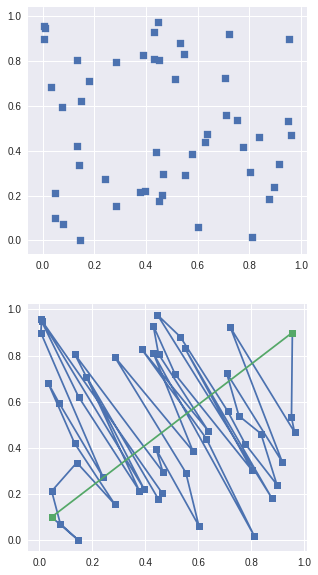

In [0]:
plt.figure(figsize=(5,10))
plt.subplot(2,1,1)
plt.scatter(original_graph[0],original_graph[1], marker='s')
plt.subplot(2,1,2)
plt.plot(test_graph[:,0], test_graph[:,1], marker='s')
plt.plot([test_graph[-1,0],test_graph[0,0]], 
         [test_graph[-1,1],test_graph[0,1]], marker='s')
# for i in range(50):
#     plt.plot(original_graph[0, int(test_idx[i,0])], original_graph[1,int(test_idx[i,0])], marker='s')